In [1]:
#####HMC Joint Geometric Topic Model#####
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy.linalg
import gensim
from scipy import sparse
from scipy.special import gammaln
from pandas.tools.plotting import scatter_matrix
from numpy.random import *
from scipy import optimize
import seaborn as sns
import time

C:\Users\sana\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
##多項分布の乱数を生成する関数
def rmnom(pr, n, k, no):
    z_id = np.argmax((np.cumsum(pr, axis=1) > np.random.rand(n).reshape(n, 1)), axis=1)
    Z = sparse.coo_matrix((np.repeat(1, n), (no, np.array(z_id))), shape=(n, k))   #スパース行列の設定
    return Z

In [3]:
####データの発生####
##データの設定
k = 15
hh = 2500   #ユーザー数
item = 1000   #場所数
w = np.random.poisson(np.random.gamma(30, 1/0.225, hh), hh)   #訪問数
f = np.sum(w)   #総訪問数

In [4]:
##IDとインデックスの設定
#IDの設定
no = np.array(range(f))
d_id = np.repeat(range(hh), w)
t_id = np.zeros(f, dtype='int')
for i in range(hh):
    t_id[d_id==i] = range(w[i])
geo_id01 = np.repeat(range(hh), np.repeat(item, hh))    
geo_id02 = np.repeat(range(item), hh).reshape(item, hh).T.reshape(-1)

In [5]:
#インデックスの設定
index1 = np.array(range(f))
index2 = np.array(range(hh*item))
d_index = [i for i in range(hh)]
geo_index = [i for i in range(hh)]
for i in range(hh):
    d_index[i] = index1[d_id==i]
    geo_index[i] = index2[geo_id01==i] 

1


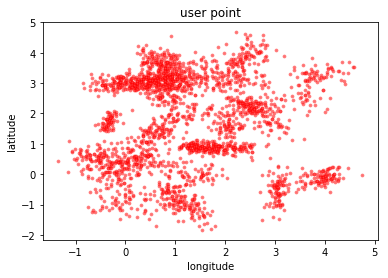

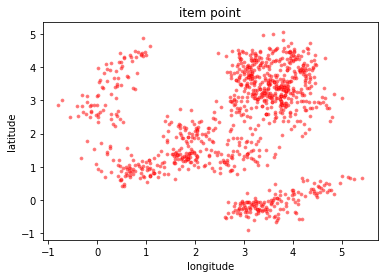

In [6]:
##すべてのアイテムが生成されるまで繰り返す
rp = 0
while True:
    rp = rp + 1
    print(rp)
    
    ##ユーザーとアイテムの経緯度を生成
    #ユーザーの場所集合を生成
    s = 30
    rate = np.random.dirichlet(np.repeat(2.0, s), 1).reshape(-1)
    point = np.dot(np.random.multinomial(1, rate, hh), range(s))

    #経緯度を生成
    longitude = np.array((0, 5)); latitude = np.array((0, 5))
    geo_user0 = np.zeros((hh, 2))
    for j in range(s):
        index = np.array(range(hh))[point==j]
        mu = np.append(np.random.uniform(longitude[0], longitude[1], 1), np.random.uniform(latitude[0], latitude[1], 1))
        cov = np.diag(np.random.uniform(0.01, 0.15, 2))
        value = np.random.uniform(-0.6, 0.6, 1) * np.prod(np.sqrt(np.diag(cov)))
        cov[0, 1] = value; cov[1, 0] = value
        geo_user0[index, :] = np.random.multivariate_normal(mu, cov, index.shape[0])

    geo_user = np.min(geo_user0) + geo_user0
    plt.scatter(geo_user[:, 0], geo_user[:, 1], s=3, c="pink", alpha=0.5, linewidths="2",
                edgecolors="red")
    plt.title("user point")
    plt.xlabel("longitude")
    plt.ylabel("latitude")
    plt.show()

    #スポットの場所集合を生成
    s = 25
    rate = np.random.dirichlet(np.repeat(2.0, s), 1).reshape(-1)
    point = np.dot(np.random.multinomial(1, rate, item), range(s))

    #経緯度を生成
    longitude = np.array((0, 5)); latitude = np.array((0, 5))
    geo_item0 = np.zeros((item, 2))
    for j in range(s):
        index = np.array(range(item))[point==j]
        mu = np.append(np.random.uniform(longitude[0], longitude[1], 1), np.random.uniform(latitude[0], latitude[1], 1))
        cov = np.diag(np.random.uniform(0.01, 0.15, 2))
        value = np.random.uniform(-0.6, 0.6, 1) * np.prod(np.sqrt(np.diag(cov)))
        cov[0, 1] = value; cov[1, 0] = value
        geo_item0[index, :] = np.random.multivariate_normal(mu, cov, index.shape[0])

    geo_item = np.min(geo_item0) + geo_item0
    plt.scatter(geo_item[:, 0], geo_item[:, 1], s=3, c="pink", alpha=0.5, linewidths="2",
                edgecolors="red")
    plt.title("item point")
    plt.xlabel("longitude")
    plt.ylabel("latitude")
    plt.show()

    #ユーザーと場所のユークリッド距離
    d0 = np.sqrt(np.sum(np.power(geo_user[geo_id01, ] - geo_item[geo_id02, ], 2), axis=1))

    ##パラメータを生成
    #トピック分布を生成
    alpha1 = np.repeat(0.1, k)
    theta = np.random.dirichlet(alpha1, hh)
    thetat = theta

    #場所分布の生成
    alpha2 = 2.25
    beta = 1.0; betat = beta   #バンド幅のパラメータ
    phi = np.random.multivariate_normal(np.repeat(0, item-1), np.diag((np.repeat(np.power(alpha2, 2), item-1))), k); phit = phi
    phi_par = np.hstack((np.repeat(0, k).reshape(k, 1), phi))
    
    ##応答変数の生成
    Z = np.zeros((f, k))
    VX = np.zeros((hh, item))
    d = np.zeros(f)
    y = np.zeros(f)

    for i in range(hh):
        #トピックの生成
        z = np.random.multinomial(1, theta[i, :], w[i])
        z_vec = np.dot(z, range(k))

        #訪問確率を決定
        par = np.exp(phi_par[z_vec, :]) * np.repeat(np.exp(-beta/2 * d0[geo_index[i]]), w[i]).reshape(w[i], item, order="F")
        prob = par / np.sum(par, axis=1).reshape(w[i], 1)

        #訪問した場所を生成
        v = np.array(rmnom(prob, w[i], item, np.array(range(w[i]))).todense())
        v_vec = np.dot(v, range(item))

        #データの格納
        d[d_index[i]] = d0[geo_index[i]][np.array(v_vec, dtype="int")]
        Z[d_index[i], ] = z
        y[d_index[i]] = np.array(v_vec, "int")
        VX[i, ] = np.sum(v, axis=0)
        
    if(np.min(np.sum(VX, axis=0)) > 0):
        break

In [7]:
#スパース行列を作成
sparse_data = sparse.coo_matrix((np.repeat(1, f), (range(f), y)), shape=(f, item))
sparse_data_T = sparse_data.T

In [8]:
####ハミルトニアンモンテカルロ法でJoint Geometric Topic Modelを推定####
##単語ごとに尤度と負担率を計算する関数
def burden_fr(f, theta, phi, wd, w_id, k):
    #尤度を計算
    Bur = theta[w_id, :]  * phi.T[wd, ]   #トピック尤度

    #負担率を計算
    Br = Bur / np.sum(Bur, axis=1).reshape((f, 1))   #負担率
    r = np.sum(Br, axis=0) / np.sum(Br)
    return Br, Bur, r

##完全データの対数尤度の和を計算する関数
def loglike(phi, dt, d_par_matrix, d_id, hh, item, item_vec):
    #パラメータを設定
    phi_par = np.exp(np.append(0, phi))

    #場所選択確率を設定
    denom_par = (d_par_matrix * np.repeat(phi_par, hh).reshape(hh, item, order="F"))[d_id, ]   #分母を設定
    prob_spot = denom_par / np.dot(denom_par, item_vec).reshape(d_id.shape[0], 1)   #トピックごとに選択確率を計算

    #完全データの対数尤度の和
    LL = np.sum(np.log(np.dot(dt * prob_spot, item_vec)))
    return LL

##場所選択可率のパラメータをサンプリングするための関数
#場所選択確率パラメータの対数事後分布の微分関数
def dloglike(phi, dt, d_par_matrix, d_id, hh, item, item_vec):
    #パラメータを設定
    phi_par = np.exp(np.append(0, phi))

    #場所選択確率を設定
    denom_par = (d_par_matrix * np.repeat(phi_par, hh).reshape(hh, item, order="F"))[d_id, ]   #分母を設定
    prob_spot = denom_par / np.dot(denom_par, item_vec).reshape(d_id.shape[0], 1)   #トピックごとに選択確率を計算

    #勾配ベクトルを算出
    sc = -np.delete(np.sum(dt - prob_spot, axis=0), 0)
    return sc

#場所選択確率パラメータのリープフロッグ法を解く関数
def leapfrog(r, z, D, e, L): 
    def leapfrog_step(r, z, e):
        r2 = r - e * D(z, dt, d_par_matrix, d_id0, hh, item, item_vec) / 2
        z2 = z + e * r2
        r2 = r2 - e * D(z2, dt, d_par_matrix, d_id0, hh, item, item_vec) / 2
        return [r2, z2]   #1回の移動後の運動量と座標
    leapfrog_result = [r, z]
    for i in range(L):
        leapfrog_result = leapfrog_step(leapfrog_result[0], leapfrog_result[1], e)
    return leapfrog_result

In [9]:
##アルゴリズムの設定
R = 1000
keep = 2
burnin = 250/keep
disp = 10
LL1 = -1000000000
e = 0.03
L = 3

In [10]:
##インデックスとデータを設定
#インデックスの設定
index_f = np.array(range(f))
d_dt = sparse.csr_matrix((np.repeat(1, f), (d_id, range(f))), shape=(hh, f))

#データの設定
y = np.array(y, "int")
Data = np.array(sparse_data.todense(), dtype="int8")
d_par_matrix0 = d0.reshape(hh, item)
item_vec = np.repeat(1, item)

In [11]:
##事前分布の設定
alpha01 = 0.1
alpha02 = np.repeat(0, item-1)
inv_tau = np.linalg.inv(np.diag(np.repeat(100, item-1)))

In [12]:
##パラメータの真値
beta = betat
theta = thetat 
phi = phit

In [13]:
##初期値の設定
#パラメータの初期値
beta = 1.0
theta = np.random.dirichlet(np.repeat(1.0, k), hh)
phi = np.random.multivariate_normal(np.repeat(0, item-1), np.diag(np.repeat(0.1, item-1)), k)
phi_par = np.hstack((np.repeat(0, k).reshape(k, 1), phi))

#場所選択確率の初期値
phi_exp = np.exp(phi_par).T
d_par = np.exp(-beta/2 * d)
d_par_matrix = np.exp(-beta/2 * d0).reshape(hh, item)
denom_par = np.dot(d_par_matrix, phi_exp)[d_id, ]   #分母を設定
prob_spot = (phi_exp[y, ] * d_par.reshape(f, 1)) / denom_par   #トピックごとに選択確率を算出

In [14]:
##パラメータの格納用配列
##サンプリングの格納用配列
THETA = np.zeros((hh, k, int(R/keep)))
PHI = np.zeros((k, item-1, int(R/keep)))
SEG = np.zeros((f, k))
gamma_rate = np.zeros(k)

In [15]:
##対数尤度の基準値
#ユニグラムモデルの対数尤度
LLst = np.sum(np.dot(Data, np.log(np.sum(Data, axis=0) / f)))

#真値での対数尤度
#場所選択確率を更新
phi_exp = np.exp(np.hstack((np.repeat(0, k).reshape(k, 1), phit))).T
d_par = np.exp(-betat/2 * d)
d_par_matrix = np.exp(-betat/2 * d0).reshape(hh, item)
denom_par = np.dot(d_par_matrix, phi_exp)[d_id, ]   #分母を設定
prob_spot_best = (phi_exp[y, ] * d_par.reshape(f, 1)) / denom_par   #トピックごとに選択確率を算出 

#観測データの対数尤度
LLbest = np.sum(np.log(np.dot(thetat[d_id, ] * prob_spot_best, np.repeat(1, k))))

In [16]:
####HMC法でパラメータをサンプリング####
for rp in range(R):
    
    ##トピックをサンプリング
    #トピックの選択確率を設定
    Lho = theta[d_id, ] * prob_spot   #尤度関数
    prob_topic = Lho / np.dot(Lho, np.repeat(1, k)).reshape(f, 1)   #トピック選択確率

    #多項分布からトピックをサンプリング
    sparse_z = rmnom(prob_topic, f, k, no).tocsr()
    Zi = np.array(sparse_z.todense())
    Zi_T = Zi.T
    
    ##ユーザーごとにトピック分布のパラメータをサンプリング
    wsum = np.array(np.dot(d_dt, sparse_z).todense()) + alpha01   #ディリクレ分布のパラメータ
    theta = np.array([np.random.dirichlet(wsum[i, :], 1) for i in range(hh)]).reshape((hh, k))


    ##トピックごとに場所分布のパラメータをサンプリング
    for j in range(k):
        #トピック割当を抽出
        index = index_f[Zi[:, j]==1]
        dt = Data[index, :]
        d_id0 = d_id[index]

        #HMCの新しいパラメータを生成
        rold = np.random.normal(0, 1, item-1)   #標準正規分布からパラメータを生成
        phid = phi[j, :]

        #リープフロッグ法による1ステップ移動
        res = leapfrog(rold, phid, dloglike, e, L)
        rnew = res[0]
        phin = res[1]

        #移動前と移動後のハミルトニアン
        Hnew = -(loglike(phin, dt, d_par_matrix, d_id0, hh, item, item_vec)) + np.sum(np.power(rnew, 2))/2
        Hold = -(loglike(phid, dt, d_par_matrix, d_id0, hh, item, item_vec)) + np.sum(np.power(rold, 2))/2

        #パラメタータの採択を決定
        rand = np.random.uniform(0, 1, 1)   #一様分布から乱数を発生
        gamma = np.min(np.array((1, np.exp(Hold - Hnew))))   #採択率を決定
        gamma_rate[j] = gamma

        #alphaの値に基づき新しいphiを採択するかどうかを決定
        flag = gamma > rand
        phi[j, :] = flag*phin + (1-flag)*phid

    #場所選択確率を更新
    phi_exp = np.exp(np.hstack((np.repeat(0, k).reshape(k, 1), phi))).T
    d_par = np.exp(-beta/2 * d)
    d_par_matrix = np.exp(-beta/2 * d0).reshape(hh, item)
    denom_par = np.dot(d_par_matrix, phi_exp)[d_id, ]   #分母を設定
    prob_spot = (phi_exp[y, ] * d_par.reshape(f, 1)) / denom_par   #トピックごとに選択確率を算出

    ##パラメータの格納とサンプリング結果の表示
    #サンプリング結果の格納
    if rp%keep==0:
        mkeep = rp//keep
        THETA[:, :, mkeep] = theta
        PHI[:, :, mkeep] = phi

    #トピック割当はバーンイン期間を超えたら格納
    if rp%keep==0 & rp >= burnin:
        SEG = SEG + Zi

    if rp%disp==0:
        #対数尤度の更新
        LL = np.sum(np.log(np.dot(theta[d_id, ] * prob_spot, np.repeat(1, k))))

        #サンプリング結果を確認
        print(rp)
        print(np.round(np.array((LL, LLbest, LLst)), 1))
        print(np.round(gamma_rate, 3))

0
[-2180690.8 -1762881.4 -2087956.4]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


KeyboardInterrupt: 